# Main code

In [138]:
# This serves as a template which will guide you through the implementation of this task.  It is advised
# to first read the whole template and get a sense of the overall structure of the code before trying to fill in any of the TODO gaps
# First, we import necessary libraries:
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, RBF, Matern, WhiteKernel
import xgboost
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings("ignore")

def data_loading():
    """
    This function loads the training and test data, preprocesses it, removes the NaN values and interpolates the missing 
    data using imputation

    Parameters
    ----------
    Returns
    ----------
    X_train: matrix of floats, training input with features
    y_train: array of floats, training output with labels
    X_test: matrix of floats: dim = (100, ?), test input with features
    """
    # Load training data
    train = pd.read_csv("train.csv")
    
    #print("Training data:")
    #print("Shape:", train_df.shape)
    #print(train_df.head(2))
    #print('\n')
    
    # Load test data
    test = pd.read_csv("test.csv")

    #print("Test data:")
    #print(test_df.shape)
    #print(test_df.head(2))

    # TODO: Perform data preprocessing, imputation and extract X_train, y_train and X_test
    
    # Impute missing data using KNN Imputer for train set

    train_new = train.dropna(subset=['price_CHF'])

    num_cols = train_new.columns[1:]

    imputer = KNNImputer(n_neighbors=5)
    train_new[num_cols] = imputer.fit_transform(train_new[num_cols])
    
    # Either drop nan rows or impute for test
    test_new = test.copy()
    num_cols = test_new.columns[1:]

    imputer = KNNImputer(n_neighbors=5)
    test_new[num_cols] = imputer.fit_transform(test_new[num_cols])
    
    # Encode categorical variable (season)
    train_new["season"] = train_new["season"].astype('category')
    train_new["season"] = train_new["season"].cat.codes

    test_new["season"] = test_new["season"].astype('category')
    test_new["season"] = test_new["season"].cat.codes

    ind_cols = ['season', 'price_AUS', 'price_CZE', 'price_GER',
           'price_ESP', 'price_FRA', 'price_UK', 'price_ITA', 'price_POL', 'price_SVK']
    dep_col = 'price_CHF'
        
    # Import new data as train/test for modelling
    X_train = train_new[ind_cols]
    y_train = train_new[dep_col]
    X_test = test_new

    print("X train shape: ", X_train.shape)
    print("Y train shape: ", y_train.shape)
    print("X test shape: ", X_test.shape)

    assert (X_train.shape[1] == X_test.shape[1]) and (X_train.shape[0] == y_train.shape[0]) and (X_test.shape[0] == 100), "Invalid data shape"
    return X_train, y_train, X_test

def modeling_and_prediction(X_train, y_train, X_test):
    """
    This function defines the model, fits training data and then does the prediction with the test data 

    Parameters
    ----------
    X_train: matrix of floats, training input with 10 features
    y_train: array of floats, training output
    X_test: matrix of floats: dim = (100, ?), test input with 10 features

    Returns
    ----------
    y_test: array of floats: dim = (100,), predictions on test set
    """

    #X_train_new, X_valid, y_train_new, y_valid = train_test_split(X_train, y_train, test_size = 0.20, shuffle = True)
    X_train_new = X_train
    y_train_new = y_train

    xgbr = XGBRegressor()

    xgb_params = {'nthread':[4], #when use hyperthread, xgboost may become slower
                  'learning_rate': [.03, .05, .07, .01, .007, .09], 
                  'max_depth': [6, 7, 8, 9],
                  'min_child_weight': [4, 8, 12],
                  'subsample': [0.7, 0.8, 0.85],
                  'colsample_bytree': [0.7, 0.8, 0.85]
                  }

    gsXGB = GridSearchCV(xgbr, xgb_params, cv = 5, scoring='r2', 
                         refit=True, n_jobs = 5, verbose=True)
    gsXGB.fit(X_train, y_train)

    XGB_best = gsXGB.best_estimator_
    print("Best train score: ", gsXGB.best_score_)
    print("Model params: ", gsXGB.best_params_)
    
    y_pred = XGB_best.predict(X_test)
    
    assert y_pred.shape == (100,), "Invalid data shape"
    return y_pred

# Main function. You don't have to change this
if __name__ == "__main__":
    # Data loading
    X_train, y_train, X_test = data_loading()
    # The function retrieving optimal LR parameters
    y_pred=modeling_and_prediction(X_train, y_train, X_test)
    # Save results in the required format
    dt = pd.DataFrame(y_pred) 
    dt.columns = ['price_CHF']
    dt.to_csv('results.csv', index=False)
    print("\nResults file successfully generated!")

X train shape:  (631, 10)
Y train shape:  (631,)
X test shape:  (100, 10)
Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Best train score:  0.977129415129544
Model params:  {'colsample_bytree': 0.8, 'learning_rate': 0.09, 'max_depth': 6, 'min_child_weight': 8, 'nthread': 4, 'subsample': 0.85}

Results file successfully generated!


# Experiments start here

## EDA

### Inspect the data

In [5]:
### Inspect the data ###

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train.head()

,season,price_AUS,price_CHF,price_CZE,price_GER,price_ESP,price_FRA,price_UK,price_ITA,price_POL,price_SVK
0,spring,NaN,9.644028,-1.686248,-1.748076,-3.666005,NaN,-1.822720,-3.931031,NaN,-3.238197
1,summer,NaN,7.246061,-2.132377,-2.054363,-3.295697,-4.104759,-1.826021,NaN,NaN,-3.212894
2,autumn,-2.101937,7.620085,-1.910282,NaN,-3.388777,NaN,-2.034409,-4.073850,NaN,-3.114061
3,winter,-2.098475,8.411894,-1.903834,NaN,-3.588235,NaN,-2.214720,-4.018620,-2.330803,NaN
4,spring,-1.969687,8.926884,-1.697257,-1.331049,NaN,-3.911096,-2.388092,-4.093946,NaN,NaN


### Data Preprocessing

In [45]:
# Impute missing data using KNN Imputer for train set

train_new = train.dropna(subset=['price_CHF'])

print("Before KNN imputation train \n", train_new.isnull().sum() / len(train_new) * 100.0)
num_cols = train_new.columns[1:]

imputer = KNNImputer(n_neighbors=6)
train_new[num_cols] = imputer.fit_transform(train_new[num_cols])
    
print("\n After KNN imputation train \n", train_new.isnull().sum() / len(train_new) * 100.0)

Before KNN imputation train 
 season        0.000000
price_AUS    32.329635
price_CHF     0.000000
price_CZE    32.012678
price_GER    35.340729
price_ESP    34.706815
price_FRA    32.805071
price_UK     34.865293
price_ITA    32.805071
price_POL    30.586371
price_SVK    34.548336
dtype: float64

 After KNN imputation train 
 season       0.0
price_AUS    0.0
price_CHF    0.0
price_CZE    0.0
price_GER    0.0
price_ESP    0.0
price_FRA    0.0
price_UK     0.0
price_ITA    0.0
price_POL    0.0
price_SVK    0.0
dtype: float64


C:\Users\Admin\AppData\Local\Temp\ipykernel_5080\129278537.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_new[num_cols] = imputer.fit_transform(train_new[num_cols])


In [46]:
# Either drop nan rows or impute for test

test_new = test.copy()

print("Before KNN imputation test \n", test_new.isnull().sum() / len(test_new) * 100.0)
num_cols = test_new.columns[1:]

imputer = KNNImputer(n_neighbors=6)
test_new[num_cols] = imputer.fit_transform(test_new[num_cols])
    
print("\n After KNN imputation test \n", test_new.isnull().sum() / len(test_new) * 100.0)

Before KNN imputation test 
 season        0.0
price_AUS    33.0
price_CZE    25.0
price_GER    31.0
price_ESP    39.0
price_FRA    25.0
price_UK     24.0
price_ITA    30.0
price_POL    35.0
price_SVK    34.0
dtype: float64

 After KNN imputation test 
 season       0.0
price_AUS    0.0
price_CZE    0.0
price_GER    0.0
price_ESP    0.0
price_FRA    0.0
price_UK     0.0
price_ITA    0.0
price_POL    0.0
price_SVK    0.0
dtype: float64


In [47]:
# Encode categorical variable (season)

train_new["season"] = train_new["season"].astype('category')
train_new["season"] = train_new["season"].cat.codes
train_new["season"] = train_new["season"].astype('float')

test_new["season"] = test_new["season"].astype('category')
test_new["season"] = test_new["season"].cat.codes
test_new["season"] = test_new["season"].astype('float')

C:\Users\Admin\AppData\Local\Temp\ipykernel_5080\1428641136.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_new["season"] = train_new["season"].astype('category')
C:\Users\Admin\AppData\Local\Temp\ipykernel_5080\1428641136.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_new["season"] = train_new["season"].cat.codes
C:\Users\Admin\AppData\Local\Temp\ipykernel_5080\1428641136.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

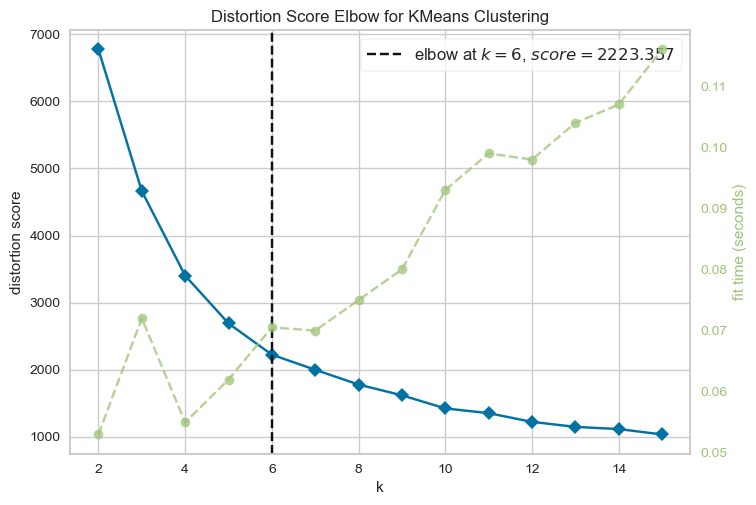

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [48]:
# Find optimal k

from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
model = KElbowVisualizer(KMeans(), k=15)
model.fit(train_new)
model.show()

## Modelling

In [49]:
ind_cols = ['season', 'price_AUS', 'price_CZE', 'price_GER',
       'price_ESP', 'price_FRA', 'price_UK', 'price_ITA', 'price_POL', 'price_SVK']
dep_col = 'price_CHF'

X_train = train_new[ind_cols]
y_train = train_new[dep_col]
X_test = test_new

print("X train shape: ", X_train.shape)
print("Y train shape: ", y_train.shape)
print("X test shape: ", X_test.shape)

X train shape:  (631, 10)
Y train shape:  (631,)
X test shape:  (100, 10)


### sklearn GP regressor

In [ ]:
kernel = Matern(nu=0.5, length_scale=1.0) + WhiteKernel

gp_model = GaussianProcessRegressor(kernel=kernel, optimizer='fmin_l_bfgs_b', random_state=None, n_restarts_optimizer=0, normalize_y=False)
gp_model.fit(X_train, y_train)

y_pred = gp_model.predict(X_test) # I don't know why it started outputting an error here for me, works fine in main.py

### XGBoost

In [126]:
import xgboost
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

X_train_new, X_valid, y_train_new, y_valid = train_test_split(X_train, y_train, test_size = 0.20, shuffle = True)

xgbr = XGBRegressor()

xgb_params = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'learning_rate': [.03, 0.05, .07, .01], 
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'subsample': [0.7],
              'colsample_bytree': [0.7]
              }

gsXGB = GridSearchCV(xgbr, xgb_params, cv = 5, scoring='r2', 
                     refit=True, n_jobs = 5, verbose=True)
gsXGB.fit(X_train, y_train)

XGB_best = gsXGB.best_estimator_

print("Best train score: ", gsXGB.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best train score:  0.9725736629960806


In [135]:
gsXGB.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.05,
 'max_depth': 6,
 'min_child_weight': 4,
 'nthread': 4,
 'subsample': 0.7}

In [127]:
y_valid_pred = XGB_best.predict(X_valid)
print("Validation set r2 score: ", r2_score(y_valid, y_valid_pred))

Validation set r2 score:  0.9970797742342704


In [128]:
y_pred = XGB_best.predict(X_test)

### TabNet

In [61]:
from sklearn.model_selection import train_test_split

X_train_new, X_valid_pre, y_train_new, y_valid_pre = train_test_split(X_train, y_train, test_size = 0.20, random_state = 0)

X_train_tab = X_train_new.to_numpy()
y_train_tab = y_train_new.to_numpy().reshape(-1, 1)
X_valid = X_valid_pre.to_numpy()
y_valid = y_valid_pre.to_numpy().reshape(-1, 1)
X_test_tab = X_test.to_numpy()

In [62]:
# Define R^2 metric

from pytorch_tabnet.metrics import Metric
from sklearn.metrics import r2_score

class r_squared(Metric):
    """
    2xAUC.
    """

    def __init__(self):
        self._name = "r_squared"
        self._maximize = True

    def __call__(self, y_true, y_score):
        """
        Compute AUC of predictions.

        Parameters
        ----------
        y_true: np.ndarray
            Target matrix or vector
        y_score: np.ndarray
            Score matrix or vector

        Returns
        -------
            float
            AUC of predictions vs targets.
        """
        return r2_score(y_true=y_true, y_pred=y_score)

In [ ]:
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.model_selection import KFold
import torch.optim

kf = KFold(n_splits=5, random_state=42, shuffle=True)
predictions_array =[]
CV_score_array    =[]
for train_index, test_index in kf.split(X_train_tab):
    X_train, X_valid = X_train_tab[train_index], X_train_tab[test_index]
    y_train, y_valid = y_train_tab[train_index], y_train_tab[test_index]
    print(X_train.shape)
    regressor = TabNetRegressor(verbose=1,seed=42, n_d=8, n_a=8, n_steps=3, gamma=1.3,
                               optimizer_fn=torch.optim.Adam,
                               optimizer_params=dict(lr=1e-3))
    regressor.fit(X_train=X_train, y_train=y_train,
              eval_set=[(X_valid, y_valid)],
              patience=20, max_epochs=2000,
              eval_metric=[r_squared])
    CV_score_array.append(regressor.best_cost)
    predictions_array.append(np.expm1(regressor.predict(X_test_tab)))

predictions = np.mean(predictions_array,axis=0)

In [100]:
import optuna
from optuna import Trial

EPOCHS = 30
BATCH_SIZE = 32

def objective(trial):
    # parameter set by optuna
    N_D = trial.suggest_int('N_D', 4, 32)
    N_A = N_D
    GAMMA = trial.suggest_float('GAMMA', 1.0, 2.0)
    N_STEPS = trial.suggest_int('N_STEPS', 1, 3, 5)
    LAMBDA_SPARSE = trial.suggest_loguniform("LAMBDA_SPARSE", 1e-5, 1e-1)
    
    # changes
    # introduced lambda-sparse
    clf = TabNetRegressor(verbose=0,seed=42, optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=1e-3),
                       scheduler_params={"step_size":4,
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='sparsemax',
                          n_d = N_D,
                          n_a = N_A,
                          gamma = GAMMA,
                          n_steps = N_STEPS,
                          lambda_sparse = LAMBDA_SPARSE)
    
    clf.fit(X_train=X_train_tab, y_train=y_train_tab,
                  eval_set=[(X_valid, y_valid)],
                  patience=20, max_epochs=2000,
                  eval_metric=['r_squared'])
    
    score = np.max(clf.best_cost)
    
    return score

In [102]:
study = optuna.create_study(direction='maximize', study_name = 'tabnet-study')

study.optimize(objective, n_trials=30, timeout = 3600*8)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-03-31 01:30:50,813] A new study created in memory with name: tabnet-study
[I 2023-03-31 01:30:51,056] Trial 0 finished with value: -7.026320428103771 and parameters: {'N_D': 26, 'GAMMA': 1.5086030298581674, 'N_STEPS': 1, 'LAMBDA_SPARSE': 0.0339694832296505}. Best is trial 0 with value: -7.026320428103771.



Early stopping occurred at epoch 20 with best_epoch = 0 and best_val_0_r_squared = -7.02632


[I 2023-03-31 01:30:51,257] Trial 1 finished with value: -6.308905925863921 and parameters: {'N_D': 20, 'GAMMA': 1.6184854362162118, 'N_STEPS': 1, 'LAMBDA_SPARSE': 0.002568434911737541}. Best is trial 1 with value: -6.308905925863921.
[I 2023-03-31 01:30:51,427] Trial 2 finished with value: -2.417377855934055 and parameters: {'N_D': 11, 'GAMMA': 1.6235242105270593, 'N_STEPS': 1, 'LAMBDA_SPARSE': 1.775963704942348e-05}. Best is trial 2 with value: -2.417377855934055.



Early stopping occurred at epoch 20 with best_epoch = 0 and best_val_0_r_squared = -6.30891

Early stopping occurred at epoch 20 with best_epoch = 0 and best_val_0_r_squared = -2.41738


[I 2023-03-31 01:30:51,594] Trial 3 finished with value: -50.43960543003019 and parameters: {'N_D': 18, 'GAMMA': 1.8063214755737405, 'N_STEPS': 1, 'LAMBDA_SPARSE': 0.025229272353492167}. Best is trial 2 with value: -2.417377855934055.
[I 2023-03-31 01:30:51,747] Trial 4 finished with value: -2.1789964279611893 and parameters: {'N_D': 14, 'GAMMA': 1.3159576186143371, 'N_STEPS': 1, 'LAMBDA_SPARSE': 0.07176035386570576}. Best is trial 4 with value: -2.1789964279611893.



Early stopping occurred at epoch 20 with best_epoch = 0 and best_val_0_r_squared = -50.43961

Early stopping occurred at epoch 20 with best_epoch = 0 and best_val_0_r_squared = -2.179


[I 2023-03-31 01:30:51,902] Trial 5 finished with value: -2.7156247788349845 and parameters: {'N_D': 4, 'GAMMA': 1.3537551005565807, 'N_STEPS': 1, 'LAMBDA_SPARSE': 0.01545632971112248}. Best is trial 4 with value: -2.1789964279611893.
[I 2023-03-31 01:30:52,079] Trial 6 finished with value: -28.33712843923939 and parameters: {'N_D': 29, 'GAMMA': 1.0998697698079054, 'N_STEPS': 1, 'LAMBDA_SPARSE': 0.008530639354417602}. Best is trial 4 with value: -2.1789964279611893.



Early stopping occurred at epoch 20 with best_epoch = 0 and best_val_0_r_squared = -2.71562

Early stopping occurred at epoch 20 with best_epoch = 0 and best_val_0_r_squared = -28.33713


[I 2023-03-31 01:30:52,236] Trial 7 finished with value: -4.171597802036969 and parameters: {'N_D': 22, 'GAMMA': 1.8003309941431809, 'N_STEPS': 1, 'LAMBDA_SPARSE': 0.002521425402044293}. Best is trial 4 with value: -2.1789964279611893.
[I 2023-03-31 01:30:52,407] Trial 8 finished with value: -0.7770421749427046 and parameters: {'N_D': 7, 'GAMMA': 1.801614258769844, 'N_STEPS': 1, 'LAMBDA_SPARSE': 1.9140458530988796e-05}. Best is trial 8 with value: -0.7770421749427046.



Early stopping occurred at epoch 20 with best_epoch = 0 and best_val_0_r_squared = -4.1716

Early stopping occurred at epoch 20 with best_epoch = 0 and best_val_0_r_squared = -0.77704


[I 2023-03-31 01:30:52,589] Trial 9 finished with value: -8.670873740487677 and parameters: {'N_D': 15, 'GAMMA': 1.5649405657640947, 'N_STEPS': 1, 'LAMBDA_SPARSE': 0.021780824309268212}. Best is trial 8 with value: -0.7770421749427046.
[I 2023-03-31 01:30:52,764] Trial 10 finished with value: -2.7156247788349845 and parameters: {'N_D': 4, 'GAMMA': 1.945845683765512, 'N_STEPS': 1, 'LAMBDA_SPARSE': 3.927720789796357e-05}. Best is trial 8 with value: -0.7770421749427046.



Early stopping occurred at epoch 20 with best_epoch = 0 and best_val_0_r_squared = -8.67087

Early stopping occurred at epoch 20 with best_epoch = 0 and best_val_0_r_squared = -2.71562


[I 2023-03-31 01:30:52,970] Trial 11 finished with value: -2.299348939858315 and parameters: {'N_D': 9, 'GAMMA': 1.289635855782639, 'N_STEPS': 1, 'LAMBDA_SPARSE': 0.0002344821047426112}. Best is trial 8 with value: -0.7770421749427046.
[I 2023-03-31 01:30:53,153] Trial 12 finished with value: -2.058950452009353 and parameters: {'N_D': 10, 'GAMMA': 1.0072654484702364, 'N_STEPS': 1, 'LAMBDA_SPARSE': 0.08865560840809066}. Best is trial 8 with value: -0.7770421749427046.



Early stopping occurred at epoch 20 with best_epoch = 0 and best_val_0_r_squared = -2.29935

Early stopping occurred at epoch 20 with best_epoch = 0 and best_val_0_r_squared = -2.05895


[I 2023-03-31 01:30:53,364] Trial 13 finished with value: -9.702007486223811 and parameters: {'N_D': 8, 'GAMMA': 1.0093078272185698, 'N_STEPS': 1, 'LAMBDA_SPARSE': 0.00036805078554859707}. Best is trial 8 with value: -0.7770421749427046.



Early stopping occurred at epoch 20 with best_epoch = 0 and best_val_0_r_squared = -9.70201


[I 2023-03-31 01:30:53,588] Trial 14 finished with value: -7.277253088408763 and parameters: {'N_D': 12, 'GAMMA': 1.1340540542025823, 'N_STEPS': 1, 'LAMBDA_SPARSE': 7.483732350908216e-05}. Best is trial 8 with value: -0.7770421749427046.



Early stopping occurred at epoch 20 with best_epoch = 0 and best_val_0_r_squared = -7.27725


[I 2023-03-31 01:30:53,792] Trial 15 finished with value: -0.7770421749427046 and parameters: {'N_D': 7, 'GAMMA': 1.4325728926392192, 'N_STEPS': 1, 'LAMBDA_SPARSE': 1.0522455023896166e-05}. Best is trial 8 with value: -0.7770421749427046.
[I 2023-03-31 01:30:53,999] Trial 16 finished with value: -5.280782220653569 and parameters: {'N_D': 6, 'GAMMA': 1.4385393822401267, 'N_STEPS': 1, 'LAMBDA_SPARSE': 1.0772548180502501e-05}. Best is trial 8 with value: -0.7770421749427046.



Early stopping occurred at epoch 20 with best_epoch = 0 and best_val_0_r_squared = -0.77704

Early stopping occurred at epoch 20 with best_epoch = 0 and best_val_0_r_squared = -5.28078


[I 2023-03-31 01:30:54,213] Trial 17 finished with value: -5.066904048372876 and parameters: {'N_D': 16, 'GAMMA': 1.7197245107702888, 'N_STEPS': 1, 'LAMBDA_SPARSE': 3.705436093786222e-05}. Best is trial 8 with value: -0.7770421749427046.
[I 2023-03-31 01:30:54,400] Trial 18 finished with value: -9.702007486223811 and parameters: {'N_D': 8, 'GAMMA': 1.9340267156870163, 'N_STEPS': 1, 'LAMBDA_SPARSE': 1.4781667074457223e-05}. Best is trial 8 with value: -0.7770421749427046.



Early stopping occurred at epoch 20 with best_epoch = 0 and best_val_0_r_squared = -5.0669

Early stopping occurred at epoch 20 with best_epoch = 0 and best_val_0_r_squared = -9.70201


[I 2023-03-31 01:30:54,598] Trial 19 finished with value: -4.7008628847087275 and parameters: {'N_D': 32, 'GAMMA': 1.456187231364616, 'N_STEPS': 1, 'LAMBDA_SPARSE': 0.00010652796038028332}. Best is trial 8 with value: -0.7770421749427046.



Early stopping occurred at epoch 20 with best_epoch = 0 and best_val_0_r_squared = -4.70086

Early stopping occurred at epoch 20 with best_epoch = 0 and best_val_0_r_squared = -1.53082


[I 2023-03-31 01:30:54,799] Trial 20 finished with value: -1.5308239200528395 and parameters: {'N_D': 13, 'GAMMA': 1.7121631873744443, 'N_STEPS': 1, 'LAMBDA_SPARSE': 1.0096769024140615e-05}. Best is trial 8 with value: -0.7770421749427046.
[I 2023-03-31 01:30:55,003] Trial 21 finished with value: -1.5308239200528395 and parameters: {'N_D': 13, 'GAMMA': 1.7041610671091998, 'N_STEPS': 1, 'LAMBDA_SPARSE': 1.0653972443886144e-05}. Best is trial 8 with value: -0.7770421749427046.
[I 2023-03-31 01:30:55,196] Trial 22 finished with value: -5.280782220653569 and parameters: {'N_D': 6, 'GAMMA': 1.850251735093088, 'N_STEPS': 1, 'LAMBDA_SPARSE': 2.82758459113102e-05}. Best is trial 8 with value: -0.7770421749427046.



Early stopping occurred at epoch 20 with best_epoch = 0 and best_val_0_r_squared = -1.53082

Early stopping occurred at epoch 20 with best_epoch = 0 and best_val_0_r_squared = -5.28078


[I 2023-03-31 01:30:55,347] Trial 23 finished with value: -9.702007486223811 and parameters: {'N_D': 8, 'GAMMA': 1.711742581699822, 'N_STEPS': 1, 'LAMBDA_SPARSE': 2.8229334277551386e-05}. Best is trial 8 with value: -0.7770421749427046.
[I 2023-03-31 01:30:55,521] Trial 24 finished with value: -1.975530960707517 and parameters: {'N_D': 17, 'GAMMA': 1.8762382595885505, 'N_STEPS': 1, 'LAMBDA_SPARSE': 8.891331465269941e-05}. Best is trial 8 with value: -0.7770421749427046.



Early stopping occurred at epoch 20 with best_epoch = 0 and best_val_0_r_squared = -9.70201

Early stopping occurred at epoch 20 with best_epoch = 0 and best_val_0_r_squared = -1.97553


[I 2023-03-31 01:30:55,712] Trial 25 finished with value: -2.417377855934055 and parameters: {'N_D': 11, 'GAMMA': 1.6333578287495751, 'N_STEPS': 1, 'LAMBDA_SPARSE': 1.1792665743377679e-05}. Best is trial 8 with value: -0.7770421749427046.
[I 2023-03-31 01:30:55,863] Trial 26 finished with value: -0.7770421749427046 and parameters: {'N_D': 7, 'GAMMA': 1.977991415191545, 'N_STEPS': 1, 'LAMBDA_SPARSE': 5.2227851716649126e-05}. Best is trial 8 with value: -0.7770421749427046.



Early stopping occurred at epoch 20 with best_epoch = 0 and best_val_0_r_squared = -2.41738

Early stopping occurred at epoch 20 with best_epoch = 0 and best_val_0_r_squared = -0.77704


[I 2023-03-31 01:30:56,046] Trial 27 finished with value: -5.280782220653569 and parameters: {'N_D': 6, 'GAMMA': 1.9579884505057916, 'N_STEPS': 1, 'LAMBDA_SPARSE': 4.538709264976022e-05}. Best is trial 8 with value: -0.7770421749427046.
[I 2023-03-31 01:30:56,233] Trial 28 finished with value: -5.280782220653569 and parameters: {'N_D': 6, 'GAMMA': 1.9891711022250755, 'N_STEPS': 1, 'LAMBDA_SPARSE': 2.1208155818724227e-05}. Best is trial 8 with value: -0.7770421749427046.



Early stopping occurred at epoch 20 with best_epoch = 0 and best_val_0_r_squared = -5.28078

Early stopping occurred at epoch 20 with best_epoch = 0 and best_val_0_r_squared = -5.28078


[I 2023-03-31 01:30:56,439] Trial 29 finished with value: -18.067457061011503 and parameters: {'N_D': 24, 'GAMMA': 1.8828050277705122, 'N_STEPS': 1, 'LAMBDA_SPARSE': 0.00010533710763016179}. Best is trial 8 with value: -0.7770421749427046.



Early stopping occurred at epoch 20 with best_epoch = 0 and best_val_0_r_squared = -18.06746
Number of finished trials: 30
Best trial: {'N_D': 7, 'GAMMA': 1.801614258769844, 'N_STEPS': 1, 'LAMBDA_SPARSE': 1.9140458530988796e-05}


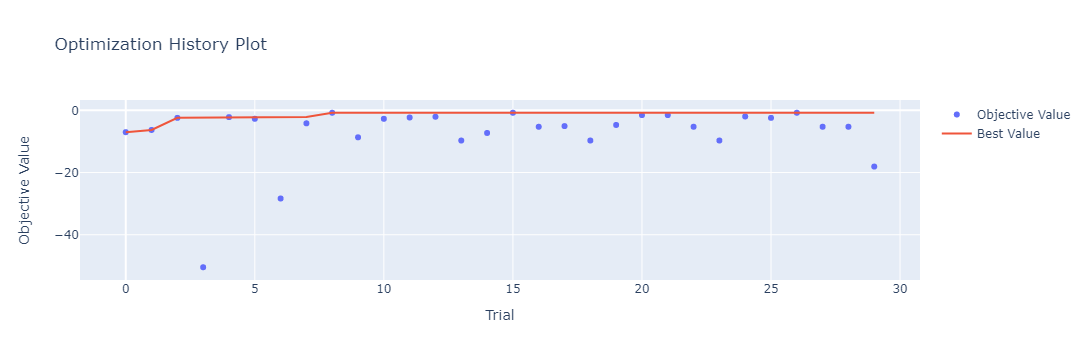

In [103]:
from optuna.visualization import plot_optimization_history

plot_optimization_history(study)

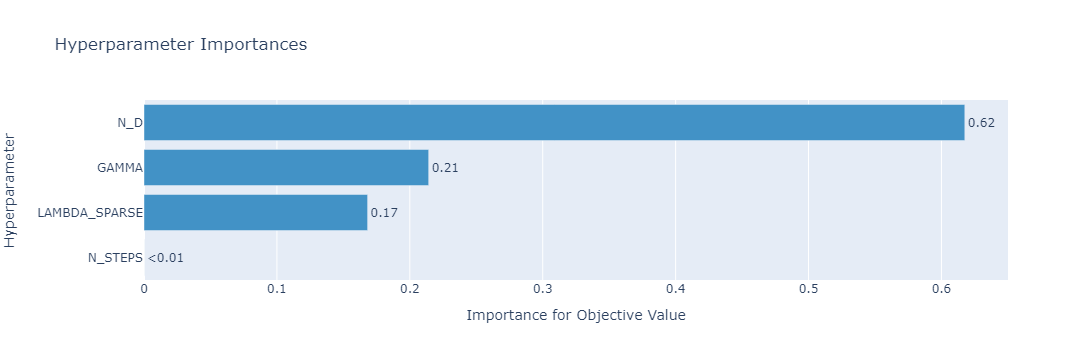

In [104]:
from optuna.visualization import plot_param_importances

plot_param_importances(study)

In [105]:
params_tb = study.best_trial.params
print(params_tb)

{'N_D': 7, 'GAMMA': 1.801614258769844, 'N_STEPS': 1, 'LAMBDA_SPARSE': 1.9140458530988796e-05}


In [107]:
TabNet_params = study.best_params
TabNet_params

{'N_D': 7,
 'GAMMA': 1.801614258769844,
 'N_STEPS': 1,
 'LAMBDA_SPARSE': 1.9140458530988796e-05}

In [113]:
final_params = dict(n_d=TabNet_params['N_D'], n_steps=TabNet_params['N_STEPS'], gamma=TabNet_params['GAMMA'],
                     lambda_sparse=TabNet_params['LAMBDA_SPARSE'], optimizer_fn=torch.optim.Adam,
                     optimizer_params=dict(lr=1e-3, weight_decay=1e-5), verbose =0)

X_train_tab = X_train.to_numpy()
y_train_tab = y_train.to_numpy().reshape(-1, 1)

regressor = TabNetRegressor(**final_params)
regressor.fit(X_train=X_train_tab, y_train=y_train_tab, max_epochs=100, eval_metric=['r_squared'])

y_pred = regressor.predict(X_test.to_numpy())

In [115]:
y_pred.shape

(100, 1)

### Write submission file

In [130]:
dt = pd.DataFrame(y_pred) 
dt.columns = ['price_CHF']
dt.to_csv('results.csv', index=False)